# 1a. Filter for high-quality genomes to download

In this notebook, we will use __`pyphylon`__'s `download` and `qcqa` modules to select candidate genomes to download for pangenome generation.

In this example we will select genomes for download from [BV-BRC](https://www.bv-brc.org/)

## Setup

In [30]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from pyphylon.downloads import get_scaffold_n50_for_species
from pyphylon.util import load_config
import pyphylon.qcqa as qcqa
import os

In [ ]:
plt.rcParams["figure.dpi"] = 200
sns.set_palette("deep")
sns.set_context("paper")
sns.set_style("whitegrid")


In [27]:
CONFIG = load_config("config.yml")
WORKDIR = CONFIG["WORKDIR"]
SPECIES_NAME = CONFIG["SPECIES_NAME"]
GENOMES_FILE = CONFIG["GENOMES_FILE"]
METADATA_FILE = CONFIG["METADATA_FILE"]

In [28]:
summary = pd.read_csv(GENOMES_FILE, index_col=0, dtype=object, sep='\t')
metadata = pd.read_csv(METADATA_FILE, index_col=0, dtype=object, sep='\t')

summary.shape

(793275, 19)

In [29]:
summary.genome_name.str.contains(SPECIES_NAME).sum()

np.int64(2289)

# Filter metadata for species of interest

In [18]:
# How many strains of the species/genus are available
species_summary = qcqa.filter_by_species(summary, CONFIG['SPECIES_NAME'])

display(
    species_summary.shape,
    species_summary.head()
)

(2286, 19)

,genome_name,taxon_id,genome_status,genome_length,gc_content,contig_l50,contig_n50,chromosomes,plasmids,contigs,patric_cds,refseq_cds,trna,rrnacoarse_consistency,fine_consistency,checkm_completeness,checkm_contamination,genome_qualitydate_created,date_modified
genome_id,,,,,,,,,,,,,,,,,,,
1.314547e+03,Streptococcus pyogenes,1314,Plasmid,19203,34.39,NaN,NaN,NaN,1,1,25,21,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-30T07:25:44.857Z
1.314540e+03,Streptococcus pyogenes,1314,Plasmid,28975,34.76,NaN,NaN,NaN,1,1,38,35,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-29T17:49:02.717Z
1.210041e+06,Streptococcus pyogenes 06BA18369,1210041,WGS,1813404,38.4,9,71565,0,0,47,1825,0,30,NaN,99.0,100.0,0.0,NaN,2015-03-16T03:17:09.594Z
1.314407e+03,Streptococcus pyogenes 1004,1314,Complete,1842099,38.30196,1,1842099,1,0,1,1798,1706,67,NaN,99.9,100.0,0.0,NaN,2023-04-21T00:08:53.590Z
1.314407e+03,Streptococcus pyogenes 1039,1314,Complete,1856557,38.30591,1,1856557,1,0,1,1827,1734,67,NaN,99.8,100.0,0.0,NaN,2023-04-21T00:00:24.086Z


## Plot unfiltered dataset

In [19]:
# Find the scaffold N50 score of the reference genome for the organism of interest
# Either visit the NCBI website or retrieve it using the following method (~20 seconds)
scaffold_n50 = get_scaffold_n50_for_species(species_summary.taxon_id.mode().values[0])
scaffold_n50

2025-01-29 12:56:09,531 - INFO - Fetching reference genome link for taxon ID 1314
2025-01-29 12:56:09,532 - INFO - ====== WebDriver manager ======
2025-01-29 12:56:10,277 - INFO - Get LATEST chromedriver version for google-chrome
2025-01-29 12:56:10,305 - INFO - Get LATEST chromedriver version for google-chrome
2025-01-29 12:56:10,341 - INFO - Driver [C:\Users\jon\.wdm\drivers\chromedriver\win64\131.0.6778.264\chromedriver-win32/chromedriver.exe] found in cache
2025-01-29 12:56:20,117 - INFO - Found reference genome link: /datasets/genome/GCF_900475035.1/
2025-01-29 12:56:20,118 - INFO - Fetching Scaffold N50 value from https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_900475035.1/
2025-01-29 12:56:20,119 - INFO - ====== WebDriver manager ======
2025-01-29 12:56:20,840 - INFO - Get LATEST chromedriver version for google-chrome
2025-01-29 12:56:20,871 - INFO - Get LATEST chromedriver version for google-chrome
2025-01-29 12:56:20,901 - INFO - Driver [C:\Users\jon\.wdm\drivers\chromedriver

1700000

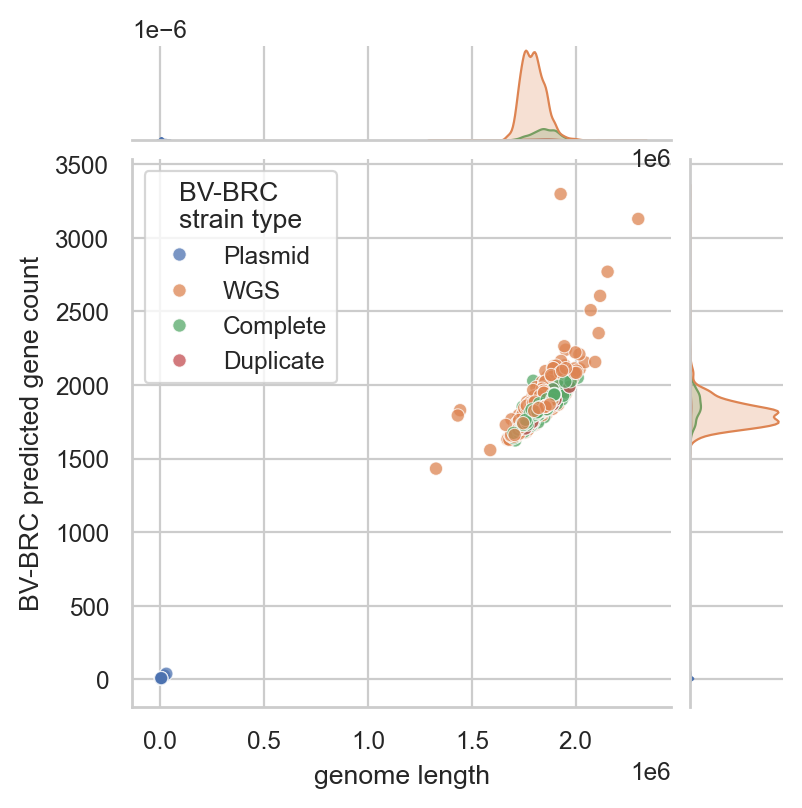

In [20]:
# Initial unfiltered strain plot
h = sns.jointplot(
    data=species_summary,
    x="genome_length",
    y="patric_cds",
    hue="genome_status",
    alpha=0.75,
    height=4
)

h.ax_joint.legend(
    title='BV-BRC\nstrain type',
)

h.ax_joint.set_xlabel("genome length")
h.ax_joint.set_ylabel("BV-BRC predicted gene count")
plt.show()

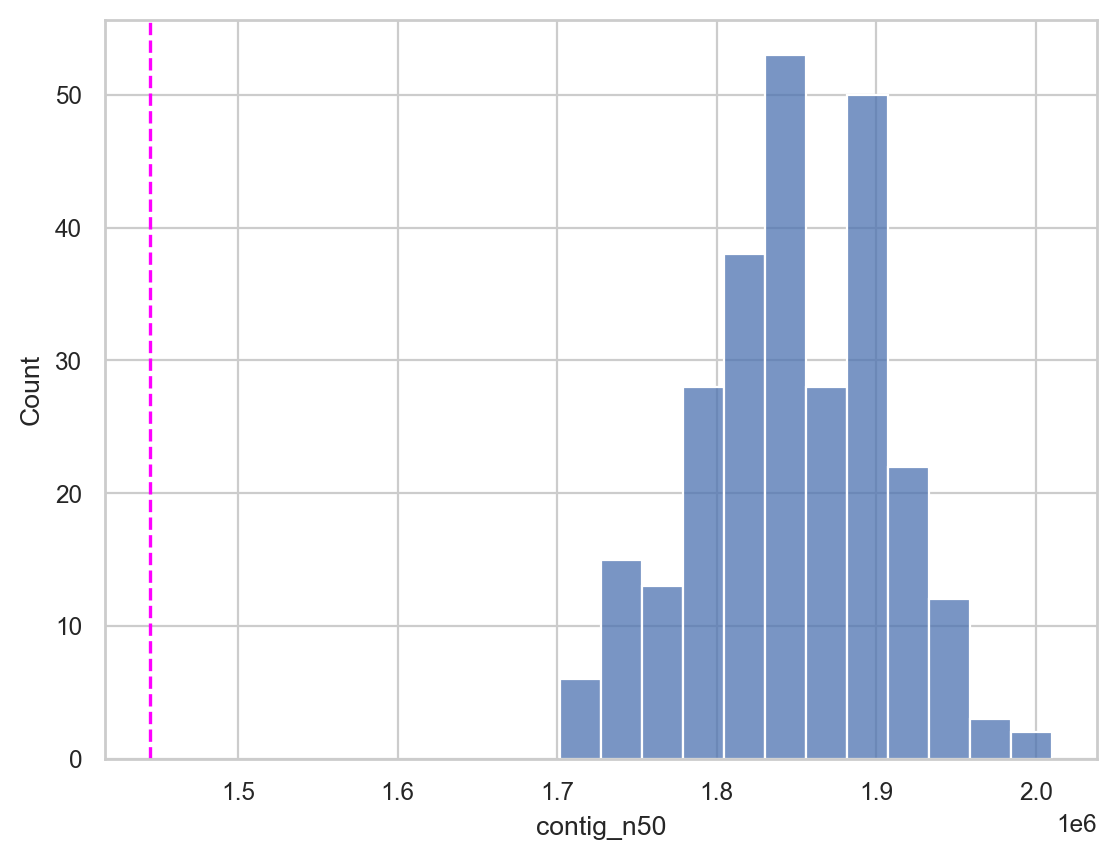

In [21]:
# Find reference strain N50 value from NCBI Genome and multiply by 0.85
# If your species/genus has multiple reference strains, pick the smallest by genome length

# Only applies for Complete sequences
species_complete_summary = species_summary[species_summary.genome_status == 'Complete']

fig, ax = plt.subplots()

# Set threshold as 0.85 * Scaffold N50 score
species_ref_n50 = scaffold_n50
min_thresh_n50 = int(0.85 * species_ref_n50)

# Most (if not all) Complete sequences pass this threshold
sns.histplot(species_complete_summary.contig_n50.dropna().astype('int'), ax=ax)
plt.axvline(x=min_thresh_n50, color='#ff00ff', linestyle='--')

In [22]:
species_summary

,genome_name,taxon_id,genome_status,genome_length,gc_content,contig_l50,contig_n50,chromosomes,plasmids,contigs,patric_cds,refseq_cds,trna,rrnacoarse_consistency,fine_consistency,checkm_completeness,checkm_contamination,genome_qualitydate_created,date_modified
genome_id,,,,,,,,,,,,,,,,,,,
1.314547e+03,Streptococcus pyogenes,1314,Plasmid,19203,34.39,NaN,NaN,NaN,1,1,25,21,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-30T07:25:44.857Z
1.314540e+03,Streptococcus pyogenes,1314,Plasmid,28975,34.76,NaN,NaN,NaN,1,1,38,35,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-29T17:49:02.717Z
1.210041e+06,Streptococcus pyogenes 06BA18369,1210041,WGS,1813404,38.4,9,71565,0,0,47,1825,0,30,NaN,99.0,100.0,0.0,NaN,2015-03-16T03:17:09.594Z
1.314407e+03,Streptococcus pyogenes 1004,1314,Complete,1842099,38.30196,1,1842099,1,0,1,1798,1706,67,NaN,99.9,100.0,0.0,NaN,2023-04-21T00:08:53.590Z
1.314407e+03,Streptococcus pyogenes 1039,1314,Complete,1856557,38.30591,1,1856557,1,0,1,1827,1734,67,NaN,99.8,100.0,0.0,NaN,2023-04-21T00:00:24.086Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.314271e+03,Streptococcus pyogenes strain spy-1326,1314,WGS,2004671,38.558548,5,183845,0,0,83,2098,1955,59,NaN,98.1,NaN,NaN,NaN,2020-03-26T19:24:23.549Z
1.314271e+03,Streptococcus pyogenes strain spy-1397,1314,WGS,1995610,38.41199,5,130952,0,0,49,2082,1938,56,NaN,98.2,NaN,NaN,NaN,2020-03-26T19:24:17.073Z
1.314271e+03,Streptococcus pyogenes strain spy-498,1314,WGS,2002928,38.4525,4,210847,0,0,58,2083,1939,49,NaN,98.1,NaN,NaN,NaN,2020-03-26T19:22:32.696Z


## Initial Filtration Report

In [23]:
# Complete sequences get filtered by their N50 and L50 scores
# Other WGS sequences get filtered by their contig count and CheckM
# contaminaion & completeness metrics
filtered_species_summary, df_filtration = qcqa.filter_by_genome_quality(
    species_summary,
    min_thresh_n50=min_thresh_n50,
    max_contig=None,
    contamination_cutoff=None,
    completeness_cutoff=None,
    return_stats=True,
)

display(
    f'Filtered Strains:',
    filtered_species_summary.shape,
    f'------------------------------',
    f'Filtration Report',
    df_filtration
)

'Filtered Strains:'

(257, 19)

'------------------------------'

'Filtration Report'

,initial,num_filtered,remaining
prefiltration,2286,0,2286
L50/N50,2286,55,2231
contig_count,2231,148,2083
CheckM_completeness_contamination,2083,1826,257


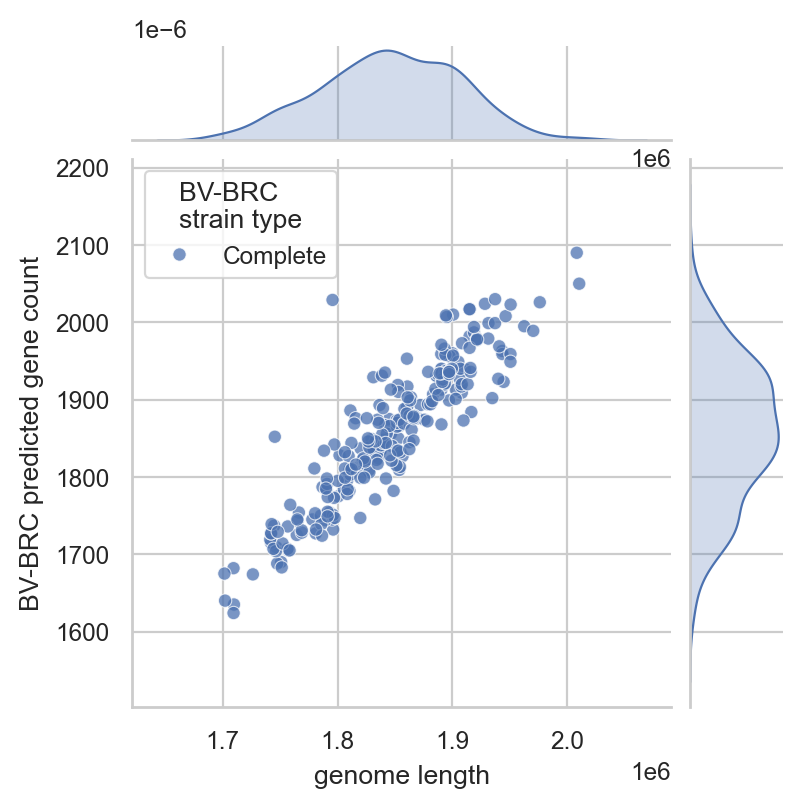

In [24]:
# Same initial plot but with only (first-pass) filtered strains
# For this plot, make sure your WGS sequences form a nice line
# Complete sequences may be all over the place

# For this example, we don't need to filter our data based on the
# distribution we see below

h = sns.jointplot(
    data=filtered_species_summary,
    x="genome_length",
    y="patric_cds",
    hue="genome_status",
    alpha=0.75,
    height=4
)

h.ax_joint.legend(
 title='BV-BRC\nstrain type'
)

h.ax_joint.set_xlabel("genome length")
h.ax_joint.set_ylabel("BV-BRC predicted gene count")
plt.show()

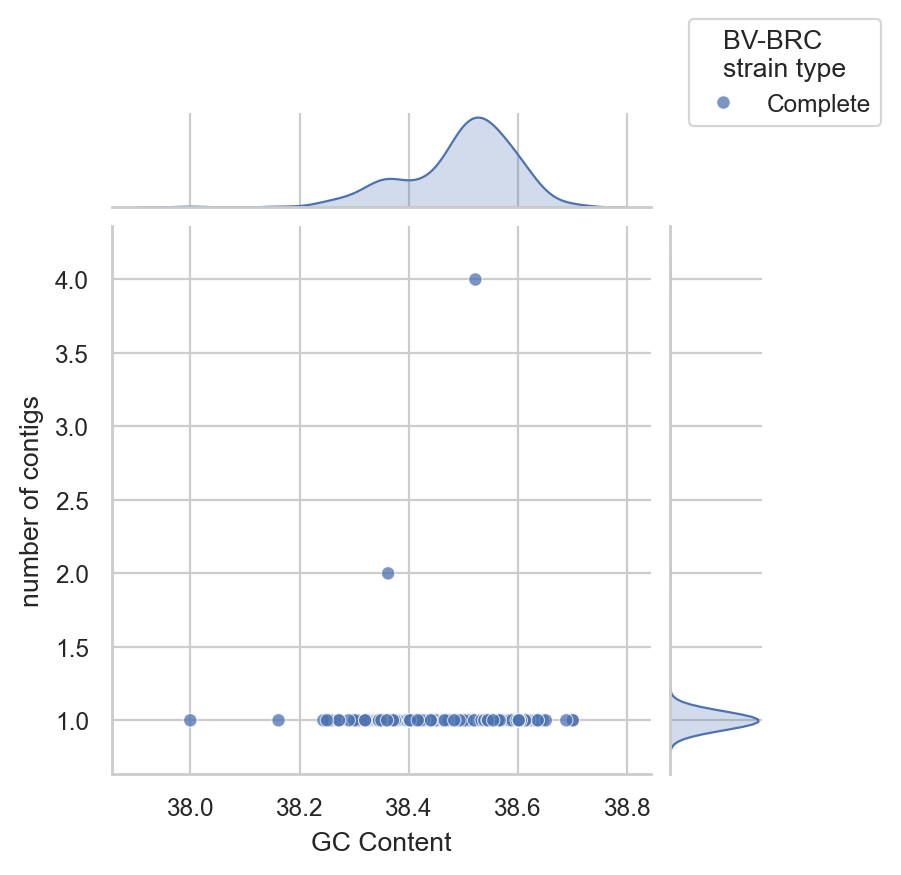

In [12]:
# Ensure GC content makes sense
# Remove any big outliers
# (in this case nothing needs filtering)

h = sns.jointplot(
    data=filtered_species_summary,
    x="gc_content",
    y="contigs",
    hue="genome_status",
    alpha=0.75,
    height=4
)

h.ax_joint.legend(
    title='BV-BRC\nstrain type',
    bbox_to_anchor=(1.45,1.4)
)

h.ax_joint.set_xlabel("GC Content")
h.ax_joint.set_ylabel("number of contigs")
plt.show()

In [13]:
filtered_species_metadata = metadata.loc[filtered_species_summary.index]
filtered_species_metadata

,genome_name,organism_name,taxon_id,genome_status,strain,serovar,biovar,pathovar,mlst,other_typing,...,motility,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,comments,additional_metadata
genome_id,,,,,,,,,,,,,,,,,,,,,
1314.4070,Streptococcus pyogenes 1004,NaN,1314,Complete,1004,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.530,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure culture
1314.4068,Streptococcus pyogenes 1039,NaN,1314,Complete,1039,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure culture
1314.4067,Streptococcus pyogenes 1042,NaN,1314,Complete,1042,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.530,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure culture
1314.4071,Streptococcus pyogenes 1044,NaN,1314,Complete,1044,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure culture
1314.3939,Streptococcus pyogenes 1095,NaN,1314,Complete,1095,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.530,genotype:emm1-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure cultured organism;biomaterial...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314.1009,Streptococcus pyogenes strain emmNA,NaN,1314,Complete,emmNA,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.612,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete genomes of 30 globally distributed Gr...,collected_by:Davies_et_al
1314.994,Streptococcus pyogenes strain emmSTG866.1,NaN,1314,Complete,emmSTG866.1,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.450,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete genomes of 30 globally distributed Gr...,collected_by:Davies_et_al
1314.2849,Streptococcus pyogenes strain iGAS376,NaN,1314,Complete,iGAS376,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete genomes of three invasive isolates of...,"collected_by:Scottish Haemophilus, Legionella,..."


## Save (first-pass) filtered genome info files for download

In [31]:
filtered_species_summary.to_csv(os.path.join(WORKDIR, 'interim/genome_summary_1a.csv'))
filtered_species_metadata.to_csv(os.path.join(WORKDIR,'interim/genome_metadata_1a.csv'))

In [33]:
df_filtration.to_csv(os.path.join(WORKDIR, 'interim/df_filtration_1a.csv'))